<a href="https://colab.research.google.com/github/Yihua0906/Credit-Card-Fraud-Detection/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
import pandas as pd

# 從 Scikit-learn 導入 PCA ，用於線性降維和特徵提取
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import time
import joblib
import os
# CLassifer
from sklearn.ensemble import RandomForestClassifier


# 其他工具庫
from sklearn.model_selection import train_test_split




# 生成少數類的合成樣本以平衡數據
from imblearn.over_sampling import SMOTE,ADASYN


# 評估指標
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# 從 collections 導入 Counter，用於統計數據集中類別的數量
from collections import Counter

# 交叉驗證，後者保持類別比例
from sklearn.model_selection import KFold, StratifiedKFold

# 導入 warnings 模組並設置忽略警告訊息，提升代碼可讀性
import warnings
warnings.filterwarnings("ignore")

# Google Drive 整合
try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# 掛載 Google Drive
if IN_COLAB:
    drive.mount('/content/drive')
    # 設定保存路徑，請根據您的實際情況調整
    save_path = '/content/drive/MyDrive/專案資料集/信用卡詐騙'
    # 確保目錄存在
    os.makedirs(save_path, exist_ok=True)
else:
    # 如果不在 Colab 中運行，則使用當前目錄
    save_path = './'
    print("未在 Google Colab 環境中運行，將保存到本地目錄。")

print(f"模型和報告將保存到: {save_path}")

# 讀取信用卡詐欺數據集
df = pd.read_csv('/content/drive/My Drive/專案資料集/信用卡詐騙/creditcard.csv')
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
模型和報告將保存到: /content/drive/MyDrive/專案資料集/信用卡詐騙


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.describe()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# 檢查是否有缺失值
print("檢查每一欄的缺失值數量：")
print(df.isnull().sum())

# 檢查是否有任何缺失值（總結）
print("\n是否有任何缺失值：", df.isnull().any().any())

檢查每一欄的缺失值數量：
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

是否有任何缺失值： False


In [ ]:
# 找出包含缺失值的行
rows_with_missing = df[df.isnull().any(axis=1)]
print("包含缺失值的行：")
print(rows_with_missing)

包含缺失值的行：
Empty DataFrame
Columns: [Time, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, Amount, Class]
Index: []

[0 rows x 31 columns]


In [ ]:
# 刪除含缺失值的行
df_cleaned = df.dropna()

# 檢查結果
print("清理後的數據形狀：", df_cleaned.shape)
print("清理後的缺失值數量：")
print(df_cleaned.isnull().sum())

清理後的數據形狀： (284807, 31)
清理後的缺失值數量：
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [ ]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


標準化


In [ ]:
from sklearn.preprocessing import RobustScaler
rob_scaler = RobustScaler()

# 標準化 Amount 和 Time，創建新欄位
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# 刪除原始的 Amount 和 Time 欄位
df = df.drop(['Amount', 'Time'], axis=1)

# 將 scaled_amount 和 scaled_time 移到前面
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']
df = df.drop(['scaled_amount', 'scaled_time'], axis=1)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)
# 檢查標準化後的前幾行
print("標準化後的前 5 行：")
print(df.head())

標準化後的前 5 行：
   scaled_amount  scaled_time        V1        V2        V3        V4  \
0       1.783274    -0.994983 -1.359807 -0.072781  2.536347  1.378155   
1      -0.269825    -0.994983  1.191857  0.266151  0.166480  0.448154   
2       4.983721    -0.994972 -1.358354 -1.340163  1.773209  0.379780   
3       1.418291    -0.994972 -0.966272 -0.185226  1.792993 -0.863291   
4       0.670579    -0.994960 -1.158233  0.877737  1.548718  0.403034   

         V5        V6        V7        V8  ...       V20       V21       V22  \
0 -0.338321  0.462388  0.239599  0.098698  ...  0.251412 -0.018307  0.277838   
1  0.060018 -0.082361 -0.078803  0.085102  ... -0.069083 -0.225775 -0.638672   
2 -0.503198  1.800499  0.791461  0.247676  ...  0.524980  0.247998  0.771679   
3 -0.010309  1.247203  0.237609  0.377436  ... -0.208038 -0.108300  0.005274   
4 -0.407193  0.095921  0.592941 -0.270533  ...  0.408542 -0.009431  0.798278   

        V23       V24       V25       V26       V27       V28  Class

In [ ]:
import threading

def connect_button():
    print("Connect button pressed")
    threading.Timer(300.0, connect_button).start()  # 每秒執行一次

connect_button()  # 啟動定時執行


Connect button pressed


信用卡詐騙檢測模型評估報告
日期: 2025年3月24日

1. 數據分佈
原始數據: {0: 284315, 1: 492}
ADASYN後: {0: 227451, 1: 45516}

2. 基本評估指標
AUC: 0.9884
F1分數: 0.4780
精確率: 0.3271
召回率: 0.8878
混淆矩陣:
[[56685   179]
 [   11    87]]

3. 最佳閾值結果
最佳閾值: 0.9301
F1分數: 0.8478
精確率: 0.9070
召回率: 0.7959


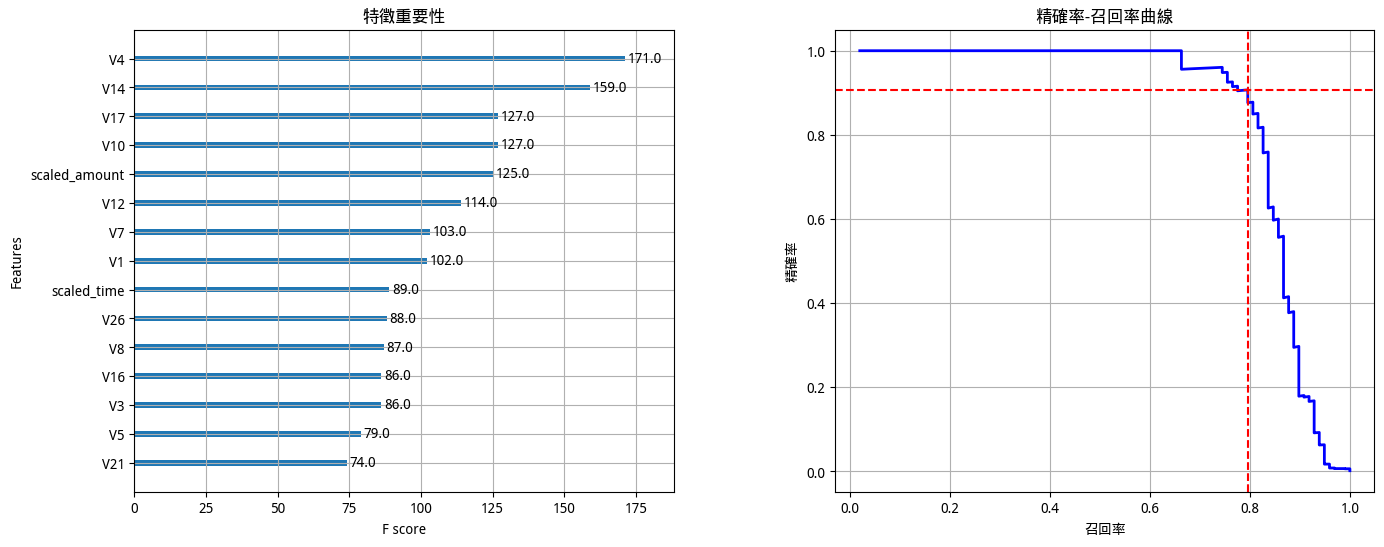


模型已保存至: /content/drive/MyDrive/專案資料集/信用卡詐騙/xgboost_model.pkl
評估報告已保存至: /content/drive/MyDrive/專案資料集/信用卡詐騙/evaluation_report.txt
圖表已保存至: /content/drive/MyDrive/專案資料集/信用卡詐騙/model_evaluation_plots.png


In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pickle
import sys
import io

# 確保輸出使用 UTF-8 編碼
if hasattr(sys.stdout, 'reconfigure'):
    sys.stdout.reconfigure(encoding='utf-8')

# 動態設置中文字體
def set_chinese_font():
    system = platform.system()
    available_fonts = [f.name for f in fm.fontManager.ttflist]

    if system == "Windows":
        if 'Microsoft YaHei' in available_fonts:
            plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
        elif 'SimHei' in available_fonts:
            plt.rcParams['font.sans-serif'] = ['SimHei']
    elif system == "Linux" or 'google.colab' in sys.modules:
        # Google Colab 或 Linux 環境，檢查並安裝字體
        if 'WenQuanYi Micro Hei' not in available_fonts:
            print("正在安裝中文字體...")
            os.system('apt-get update -qq && apt-get install -y fonts-wqy-microhei -qq')
            fm.fontManager.addfont('/usr/share/fonts/truetype/wqy/wqy-microhei.ttc')
        plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']
    elif system == "Darwin":  # Mac
        if 'Heiti TC' in available_fonts:
            plt.rcParams['font.sans-serif'] = ['Heiti TC']

    plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# 設置字體
set_chinese_font()

# 設定保存路徑
save_path = '/content/drive/MyDrive/專案資料集/信用卡詐騙'
if not os.path.exists(save_path):
    os.makedirs(save_path)

# 分離特徵和目標變數
X = df.drop('Class', axis=1)
y = df['Class']

# 分割資料集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 應用ADASYN
adasyn = ADASYN(sampling_strategy=0.2, n_neighbors=5, random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# 訓練XGBoost模型
model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    max_delta_step=5,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_resampled, y_train_resampled)

# 預測
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 計算基本評估指標
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

# 閾值優化
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * precisions[:-1] * recalls[:-1] / (precisions[:-1] + recalls[:-1] + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# 創建評估報告
evaluation_report = {
    'Data Distribution': {
        'Original': dict(Counter(y)),
        'After_ADASYN': dict(Counter(y_train_resampled))
    },
    'Model Parameters': model.get_params(),
    'Basic Metrics': {
        'AUC': auc,
        'F1_Score': f1,
        'Precision': precision,
        'Recall': recall,
        'Confusion_Matrix': cm.tolist()
    },
    'Optimized Threshold': {
        'Threshold': optimal_threshold,
        'F1_Score': f1_scores[optimal_idx],
        'Precision': precisions[optimal_idx],
        'Recall': recalls[optimal_idx]
    },
    'Classification Reports': {
        'Default_Threshold': classification_report(y_test, y_pred, output_dict=True),
        'Optimal_Threshold': classification_report(y_test, y_pred_optimal, output_dict=True)
    }
}

# 輸出格式化的評估報告
print("信用卡詐騙檢測模型評估報告")
print("==========================")
print("日期: 2025年3月24日")
print("\n1. 數據分佈")
print(f"原始數據: {evaluation_report['Data Distribution']['Original']}")
print(f"ADASYN後: {evaluation_report['Data Distribution']['After_ADASYN']}")

print("\n2. 基本評估指標")
print(f"AUC: {evaluation_report['Basic Metrics']['AUC']:.4f}")
print(f"F1分數: {evaluation_report['Basic Metrics']['F1_Score']:.4f}")
print(f"精確率: {evaluation_report['Basic Metrics']['Precision']:.4f}")
print(f"召回率: {evaluation_report['Basic Metrics']['Recall']:.4f}")
print(f"混淆矩陣:\n{np.array(evaluation_report['Basic Metrics']['Confusion_Matrix'])}")

print("\n3. 最佳閾值結果")
print(f"最佳閾值: {evaluation_report['Optimized Threshold']['Threshold']:.4f}")
print(f"F1分數: {evaluation_report['Optimized Threshold']['F1_Score']:.4f}")
print(f"精確率: {evaluation_report['Optimized Threshold']['Precision']:.4f}")
print(f"召回率: {evaluation_report['Optimized Threshold']['Recall']:.4f}")

# 繪圖
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 調整畫布大小

# 特徵重要性圖
xgb.plot_importance(model, max_num_features=15, ax=axes[0])
axes[0].set_title('特徵重要性')

# PR 曲線
axes[1].plot(recalls[:-1], precisions[:-1], 'b-', linewidth=2)
axes[1].axvline(x=recalls[optimal_idx], color='r', linestyle='--')
axes[1].axhline(y=precisions[optimal_idx], color='r', linestyle='--')
axes[1].set_xlabel('召回率')
axes[1].set_ylabel('精確率')
axes[1].set_title('精確率-召回率曲線')
axes[1].grid(True)

# 調整子圖間距
plt.subplots_adjust(wspace=0.3)

# 保存圖表
plot_save_path = os.path.join(save_path, 'model_evaluation_plots.png')
plt.savefig(plot_save_path, bbox_inches='tight', dpi=300)  # 增加解析度，確保清晰
plt.show()

# 保存模型和報告
model_save_path = os.path.join(save_path, 'xgboost_model.pkl')
report_save_path = os.path.join(save_path, 'evaluation_report.txt')

# 儲存評估報告為 .txt
with open(report_save_path, 'w', encoding='utf-8') as f:
    f.write("信用卡詐騙檢測模型評估報告\n")
    f.write("=" * 35 + "\n")
    f.write("日期: 2025年3月24日\n\n")

    f.write("1. 數據分佈\n")
    f.write(f"原始數據: {evaluation_report['Data Distribution']['Original']}\n")
    f.write(f"ADASYN後: {evaluation_report['Data Distribution']['After_ADASYN']}\n\n")

    f.write("2. 基本評估指標\n")
    f.write(f"AUC: {evaluation_report['Basic Metrics']['AUC']:.4f}\n")
    f.write(f"F1分數: {evaluation_report['Basic Metrics']['F1_Score']:.4f}\n")
    f.write(f"精確率: {evaluation_report['Basic Metrics']['Precision']:.4f}\n")
    f.write(f"召回率: {evaluation_report['Basic Metrics']['Recall']:.4f}\n")
    f.write(f"混淆矩陣:\n{np.array(evaluation_report['Basic Metrics']['Confusion_Matrix'])}\n\n")

    f.write("3. 最佳閾值結果\n")
    f.write(f"最佳閾值: {evaluation_report['Optimized Threshold']['Threshold']:.4f}\n")
    f.write(f"F1分數: {evaluation_report['Optimized Threshold']['F1_Score']:.4f}\n")
    f.write(f"精確率: {evaluation_report['Optimized Threshold']['Precision']:.4f}\n")
    f.write(f"召回率: {evaluation_report['Optimized Threshold']['Recall']:.4f}\n\n")

    f.write("4. 預設閾值的分類報告\n")
    f.write(classification_report(y_test, y_pred) + "\n")

    f.write("5. 最佳閾值的分類報告\n")
    f.write(classification_report(y_test, y_pred_optimal) + "\n")

print(f"\n模型已保存至: {model_save_path}")
print(f"評估報告已保存至: {report_save_path}")
print(f"圖表已保存至: {plot_save_path}")